# Problem set 1, Asymmetric loss regression

Let's load the data and plot the training / val data.

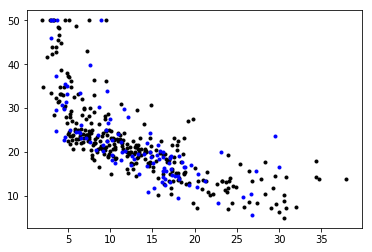

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


# Load data
dataTrain=np.loadtxt('/Users/barbarioli/Documents/Machine Learning/Assignment1/housing-train.txt')
dataVal=np.loadtxt('/Users/barbarioli/Documents/Machine Learning/Assignment1/housing-val.txt')

X_train=(dataTrain[:,np.newaxis,0])
y_train=dataTrain[:,1]
X_val=dataVal[:,np.newaxis,0]
y_val=dataVal[:,1]

plt.plot(X_train, y_train, 'k.')
plt.plot(X_val, y_val, 'b.')


First, we will solve the linear regression (under the "normal" symmetric squared loss) using the closed form solution. Let's define a couple of functions we will need.

In [2]:
def symmLoss(X, w ,y):
    loss = np.mean((y-np.dot(X,w))**2)
    return loss 

Note that the loss we have defined is the normalized squared loss

In [3]:
def lsqClosedForm(X, y):
    return np.dot(np.linalg.pinv(X), y)

Test the closed form solution: generate a toy data set from a random linear function with <b>no noise</b>. We should be able to perfectly recover w in this case (up to numerical precision).

In [4]:
X = np.hstack((np.ones([20,1]),np.random.random((20,1))))
w = np.random.random((2))
y = np.dot(X,w)
print('true weight:  '+repr(w))
w_ = lsqClosedForm(X, y)
print('function output: '+repr(w_))
if (np.allclose(w,w_)):
    print('Close enough')
else:
    print('Uh-oh')

true weight:  array([ 0.53423178,  0.90876744])
function output: array([ 0.53423178,  0.90876744])
Close enough


The function to estimate the variance of the noise and the log likelihood of the data.

In [5]:
def logLikelihood(X, w, y):
    N = X.shape[0]   # number of rows in X
    # now estimate the variance of the Gaussian noise
    v = y-np.dot(X,w)
    sigma2 = np.var(v)
    # normalized log-likelihood (mean of per-data point log-likelihood of the model given by w,sigma2)
    loglike = -1/(2*N)*1/sigma2*np.inner(y - np.dot(X,w),y - np.dot(X,w))-np.log(np.sqrt(2*np.pi*sigma2))
    return sigma2, loglike

Now let's fit linear, quadratic and cubic models to the training data, and plot the fit function. First we need to define the function that will map the original input to an expanded feature vector (including the constant term).

In [6]:
def degexpand(X, deg, C=None):
    assert X.ndim == 2
    n, m = X.shape

    # Make polynomials
    out_X = (X[..., np.newaxis] ** (1. + np.arange(deg))).reshape(n, -1)

    # Add column of ones
    out_X = np.concatenate([np.ones((out_X.shape[0], 1)), out_X], axis=1)

    if C is None:
        C = abs(out_X).max(axis=0)
    else:
        assert np.shape(C) == (out_X.shape[1],), "C must match outgoing matrix"

    out_X /= C # divide dimension-wise
    return out_X, C


We can now fit models to the training data.

degree 1:
train loss 40.092548
val loss 40.234920
sigma^2: 40.092548 
log-likelihood -3.264534

degree 2:
train loss 31.626032
val loss 31.727872
sigma^2: 31.626032 
log-likelihood -3.145929

degree 3:
train loss 30.350771
val loss 31.246330
sigma^2: 30.350771 
log-likelihood -3.125349

degree 5:
train loss 27.407330
val loss 31.274918
sigma^2: 27.407330 
log-likelihood -3.074344



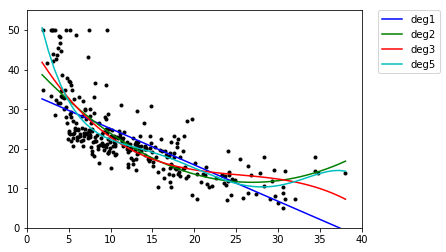

In [7]:
min_loss = np.Inf
plt.plot(X_train, y_train, 'k.')

# Try different polynomial degrees
for deg in [1,2,3,5]:
    # Expand data first; you can check how this function works in utils.py
    X, C = degexpand(X_train, deg)
    y = y_train
    
    # Get the result by applying closed-form equation
    w = lsqClosedForm(X, y)
    
    # compute loss on training set
    loss = symmLoss(X, w, y)
    
    # compute loss on val set; note -- use the same scaling matrix C as for training
    val_loss = symmLoss(degexpand(X_val, deg, C)[0], w, y_val)
    
    print('degree %d:' %(deg))
    print('train loss %.6f' %(loss))
    print('val loss %.6f' %(val_loss))
    print('sigma^2: %.6f \nlog-likelihood %.6f\n' %logLikelihood(X, w, y))
   
    if(val_loss <= min_loss):
        min_loss = val_loss
        best_param = [w,deg,C]

    color = {1:'b', 2:'g', 3:'r', 5:'c'}[deg]
    plt.plot(np.linspace(min(X_train)-.1,max(X_train)+.1), np.dot(degexpand(np.linspace(min(X_train)-.1,max(X_train)+.1).reshape((50, 1)), deg, C)[0], w), color,label='deg'+str(deg))

    
                             
    
axes = plt.gca()
axes.set_xlim([0,40])
axes.set_ylim([0,55])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [8]:
# Announce result of best selected model on validation data

dataTest=np.loadtxt('housing-val.txt')
print("Best degree:"+repr(best_param[1])+", loss (sym) on val:")
print(symmLoss(degexpand(X_val, best_param[1], best_param[2])[0], best_param[0], y_val))

Best degree:3, loss (sym) on val:
31.2463301689


(explain your logic for selecting the model)

Now we want to repeat the experiment above but under the asymmetric loss function. Since there is no closed form solution, we will need to rely on gradient descent. First we need to implement the loss function, including the option of calculating the gradient of loss with respect to model parameters

In [9]:
Question 6

The best model among the ones estimated is the 3 degree polynomial which has the smallest val loss, a great proxy for risk.
The difference in this criteria is minimum, but present nonetheless.

SyntaxError: invalid syntax (<ipython-input-9-015175fa69a1>, line 1)

In [10]:
def asymmLoss(X, w, y,alpha,_grad=False):
    """
    Get the asymmetric loss given data X, weight w and ground truth y

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values
    alpha : scalar
        indicating multiplicative factor on underprediction loss (when prediction is lower than ground truth)
    _grad : boolean
        if True, compute and return gradient of the loss w.r.t. w on the data

    Returns
    -------
    loss : a scalar
        The loss calculated by equation in problem set 1
    grad : 1D array  (only when _grad == True)
        vector of same dimension as w, containing the gradient of loss w.r.t. w
    """
    N = X.shape[0]
    A = np.less_equal(X.dot(w),y)
    B = np.sqrt(alpha) * A + (np.ones(len(A)) - A)
    C = np.diag(B)
    Res = X.dot(w) - y
    D = C.dot(Res)
    loss = np.inner(D,D)/len(A)


    if _grad:
        grad = 2/N*(np.transpose(C.dot(X))).dot(D)
        return loss, grad
    else:
        return loss
    

Test the loss and gradient function.

In [11]:
loss, grad = asymmLoss(np.array([[1,2], [1, -3]]), np.array([1,1]), np.array([4, -4]),10,_grad=True)
print("expected output")
print("7.0")
print("[ -8 -26]")
print("function output:")
print(loss)
print(grad)


expected output
7.0
[ -8 -26]
function output:
7.0
[ -8. -26.]


Since we have had the functions to calculate loss and gradient, we can implement the gradient descent algorithm.

In [12]:
def gradDescent(X, y,alpha,tol=1e-4,maxIt=10000,checkit=1000,verbose=2,lr=0.1):
    """
    Use gradient descent to min(loss(X, w, y))

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    y : 1D array
        Observed function values
    alpha : scalar
        weight on positive errors in asymmetric loss
    tol : scalar
        tolerance on loss decrease (default 1e-4)
    maxIt : scalar
        max allowed number of iterations (default 10000)
    checkit : scalar
        # of iterations after which the progress is checked for convergence
    verbose : scalar
        0  -- no progress report; 1 -- every checkit*10; 2 -- every checkit (default 2)
    lr : scalar
        learning rate (default 0.1)

    Returns
    -------
    w : 1D array
        d+1 length vector
        
    it: number of iterations until convergence
    """
    # Random initialize the weight
    w = np.random.randn(X.shape[1])
    it = 0
    lastloss = np.Inf
    while True:
        it += 1 # advance iteration count
        loss, grad = asymmLoss(X, w, y,alpha,_grad=True) # evaluate loss and compute gradient
        
        if it % checkit == 0:
            converged = it >= maxIt or loss > lastloss-tol
            lastloss = loss
            if verbose==2 or verbose==1 and it % (10*checkit) == 0:
                print('iter %d:  loss %.4f' %(it,loss))
            if converged:
                break
            
        w = w - lr * grad # update w (only if continuing updates)
       
        
    return w, it

Test gradient descent using any alpha and data generated by (random) noiseless linear model; we should recover the true w accurately (although possibly with less accuracy than the closed form solution for alpha=1)

In [13]:
X = np.hstack((np.ones([20,1]),np.random.random((20,1))))
w = np.random.random((2))
y = np.dot(X,w)
print('true weight:'+repr(w))
w_, it_ = gradDescent(X, y,10,maxIt=10000,tol=1e-6)
print('%d iterations' %it_)
print('function output:'+repr(w_))

true weight:array([ 0.99294546,  0.40630914])
iter 1000:  loss 0.0000
iter 2000:  loss 0.0000
2000 iterations
function output:array([ 0.99294546,  0.40630914])


Now we can start testing the preformance of models using aymmetric loss.

degree 1:
train loss 3.884467
val loss 3.850933

iter 10000:  loss 3.3922
degree 2:
train loss 3.391041
val loss 3.400262

iter 10000:  loss 3.4331
iter 20000:  loss 3.4202
iter 30000:  loss 3.4093
iter 40000:  loss 3.4002
iter 50000:  loss 3.3924
degree 3:
train loss 3.392363
val loss 3.399206

iter 10000:  loss 3.4444
iter 20000:  loss 3.4144
iter 30000:  loss 3.4016
iter 40000:  loss 3.3941
iter 50000:  loss 3.3883
degree 5:
train loss 3.388258
val loss 3.411133



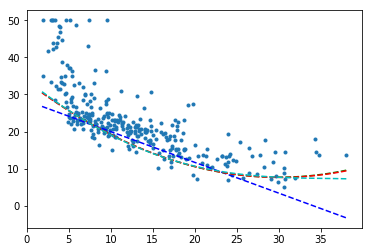

In [14]:
min_loss = np.Inf

plt.plot(X_train, y_train, '.')

alpha=.05;  # as specified in the problem set

for deg in[1,2,3,5]:
    # Expand data first
    X, C = degexpand(X_train, deg)
    y = y_train
        
    # Run gradient descent
    w, _ = gradDescent(X, y,alpha,maxIt=50000,checkit=1000,verbose=1,lr=1)
    loss = asymmLoss(X, w, y,alpha)
    val_loss = asymmLoss(degexpand(X_val, deg, C)[0], w, y_val,alpha)
    
    print('degree %d:' %(deg))
    print('train loss %.6f' %(loss))
    print('val loss %.6f\n' %(val_loss))
    
    # your code should store best_param_asym in the same format as for the symmetric loss experiments above
    if(val_loss <= min_loss):
        min_loss = val_loss
        best_param_asym = [w,deg,C]
    # Plot the function
    color = {1:'b', 2:'g', 3:'r', 5:'c'}[deg]
    plt.plot(np.linspace(min(X_train)-.1,max(X_train)+.1), np.dot(degexpand(np.linspace(min(X_train)-.1,max(X_train)+.1).reshape((50, 1)), deg, C)[0], w), color + '--')
    


In [15]:
# Announce result on validation data

dataTest=np.loadtxt('housing-val.txt')
print("Best degree:"+repr(best_param[1])+", loss (asym) on val:")
print(asymmLoss(degexpand(X_val, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_val,alpha))

Best degree:3, loss (asym) on val:
3.39920587662


In [16]:
# Now measure results on test with asymmetric loss, for both models (one learned with sym loss and one learned with asym loss)

dataTest=np.loadtxt('housing-test.txt')
X_test=(dataTest[:,np.newaxis,0])
y_test=dataTest[:,1]

print("Best degree (sym):"+repr(best_param[1]))
print('Asym loss: %.4f' %asymmLoss(degexpand(X_test, best_param[1], best_param[2])[0], best_param[0], y_test,alpha))
print('Sym loss: %.4f' %symmLoss(degexpand(X_test, best_param[1], best_param[2])[0], best_param[0], y_test))
print('Log-likelihood (symmetric): %.4f\n' %logLikelihood(degexpand(X_test, best_param[1], best_param[2])[0], best_param[0], y_test)[1])


print("Best degree (asym):"+repr(best_param_asym[1]))
print('Asym loss: %.4f' %asymmLoss(degexpand(X_test, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_test,alpha))
print('Sym loss: %.4f' %symmLoss(degexpand(X_test, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_test))
print('Log-likelihood (symmetric): %.4f\n' %logLikelihood(degexpand(X_test, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_test)[1])



Best degree (sym):3
Asym loss: 10.9697
Sym loss: 22.1586
Log-likelihood (symmetric): -2.9681

Best degree (asym):3
Asym loss: 3.7322
Sym loss: 48.7752
Log-likelihood (symmetric): -3.4696



We are done with the experiments. Here you should write clearly and succinctly what your conclusions are: what model is better? Why? In what sense? See problem set for more instructions.

In [17]:
Question 7

The best model among the ones estimated is the 3 degree polynomial which has the smallest val loss, a great proxy for risk.
The difference in this criteria is minimum, but present nonetheless.

Question 8

From the models estimated we choose the 3 degree polynomials for both the symmetric and assymetric loss. 
The difference between them is evident when it comes to val loss, since the symmetric one has a much higher loss than
the assymetric. The assymetric functions is better when we want to emphasize that a certain prediction has a worse effect 
than the other one, such as overestimating instead of underestimating. 
The symetric function is simpler and better to use in general situations. 

SyntaxError: invalid syntax (<ipython-input-17-200f103fe29b>, line 1)